In [88]:
# Import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import odeint
from types import *
import matplotlib.animation as animation
from matplotlib import rc
import pandas as pd

In [ ]:
#model variables
#x0 = gene (DNA) ON
#x1 = gene (DNA) OFF
#x2 = nascent RNA
#x3 = mRNA nuclei
#x4 = mRNA cytoplasm
#x5 = protein

#Reactions
#R1 = Gene activation
#R2 = Gene deactivation
#R3 = Nascent RNA
#R4 = mature mRNA
#R5 = mRNA Nuclear degradation
#R6 = mRNA transport to cytoplasm
#R7 = mRNA Cytoplasmic degradation
#R8 = mRNA Cytoplasmic Translation
#R9 = protein Degradation

#k1 = gene activation rate
#k2 = gene deactivation rate
#k3 = nascent RNA synthesis rate
#k4 = mature mRNA synthesis rate
#k5 = mRNA nuclear degradation rate
#k6 = mRNA transport rate
#k7 = mRNA cytoplasmic degradation rate
#k8 = mRNA cytoplasmic translation rate
#k9 = protein degradation rate


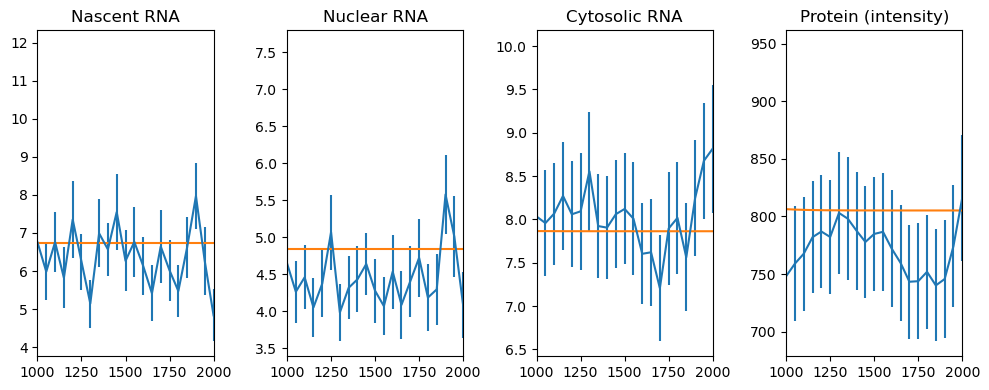

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib import rc

#NO DRUG, NO EFFECT

# Set up for inline animations in Jupyter
rc('animation', html='jshtml')

# Function to compute the time of the next reaction
def next_time(x, t, W, pars=None):
    return -np.log(np.random.rand()) / np.sum(W(x, t, pars=pars))

# Function to compute the index of the next reaction
def next_reaction(x, t, W, pars, di, ti):
    W_vals = W(x, t, pars=pars, di=di, ti=ti)
    W0 = np.sum(W_vals)
    r = np.random.rand()
    i = 0
    W_sum = W_vals[0]
    while W_sum / W0 < r:
        i += 1
        W_sum += W_vals[i]
    return i

def gillespie_drugs(x0, t0, tmax, S, W, pars, di, ti, returnFullTraj = False):
    # Initialize the time and the state
    t = t0
    x = np.array(x0)
    S = np.array(S)
    
    # Initialize the output (if requested)
    if returnFullTraj:
        times = [t0]
        states = [x0]
    
    # Run the simulation
    while t < tmax:
        # Compute the time of the next reaction
        tau = next_time(x, t, W, pars)
        t += tau
        
        # Exit the loop if the next reaction is beyond tmax
        if t > tmax:
            break
        
        # Compute the index of the next reaction
        i = next_reaction(x, t, W, pars, di, ti)
        
        # Update the state
        x = x + S[:, i]
        
        # Append the results (if requested)
        if returnFullTraj:
            times.append(t)
            states.append(x)

    # Return the results
    if returnFullTraj:
        return np.array(times), np.array(states)
    else:
        return x
    
def dxdt(x, t, pars, di, ti):
    x = np.atleast_2d(x).T
    y = (S @ W(x, t, pars, di, ti)).flatten()
    return y

def solve(S, W, x0, t, pars, di, ti, model='ODE', ntraj=1):
    if model == 'ODE':
        trajectory = odeint(dxdt, np.array(x0), t, args=(pars, di, ti))
    elif model == 'SSA':
        trajectory = np.zeros([ntraj, len(t), len(x0)])
        t0 = t[0]
        tmax = t[-1]
        for i in range(ntraj):
            times, states = gillespie_drugs(x0, t0, tmax, S, W, pars, di, ti, returnFullTraj=True)
            k = 0
            for j in range(len(times)):
                while k < len(t) and times[j] > t[k]:
                    trajectory[i, k, :] = states[j]
                    k += 1
        trajectory = np.mean(trajectory, axis=0)
    return trajectory

def compare_model_to_data(pars, di, ti, x0, drug_number, speciesDict, drug_conc=1000, path='.', model='ODE', ntraj=10):
    if drug_number == 0:
        example_df = pd.read_csv(f'{path}/NoDrug_DesignResults.csv')
    else:
        example_df = pd.read_csv(f'{path}/Drug{drug_number}_{drug_conc}nM_DesignResults.csv')

    t = np.unique(example_df['Time'])
    t_app = example_df['drug_time'].iloc[0]
    data = np.zeros((5, len(t)))
    data_std = np.zeros((5, len(t)))
    k = 0
    for tp in t:
        subdf = example_df[example_df['Time'] == tp]
        subdf = subdf[subdf['is_cell_vital'] == 1]
        data[1, k] = np.mean(subdf['num_rna_nascent'])
        data[2, k] = np.mean(subdf['num_rna_nuc'])
        data[3, k] = np.mean(subdf['num_rna_cyto'])
        data[4, k] = np.mean(subdf['Cyto_Intensity_1'])
        data_std[1, k] = np.std(subdf['num_rna_nascent']) / np.sqrt(len(subdf['num_rna_nascent']))
        data_std[2, k] = np.std(subdf['num_rna_nuc']) / np.sqrt(len(subdf['num_rna_nuc']))
        data_std[3, k] = np.std(subdf['num_rna_cyto']) / np.sqrt(len(subdf['num_rna_cyto']))
        data_std[4, k] = np.std(subdf['Cyto_Intensity_1']) / np.sqrt(len(subdf['Cyto_Intensity_1']))
        k += 1

    fig, ax = plt.subplots(1, 4, tight_layout=True, figsize=(10, 4))
    ax[0].errorbar(t, data[1], yerr=data_std[1])
    ax[1].errorbar(t, data[2], yerr=data_std[2])
    ax[2].errorbar(t, data[3], yerr=data_std[3])
    ax[3].errorbar(t, data[4], yerr=data_std[4])

    ax[0].plot([t_app, t_app], [0, max(data[1])], 'r--', label='_nolegend_')
    ax[1].plot([t_app, t_app], [0, max(data[2])], 'r--', label='_nolegend_')
    ax[2].plot([t_app, t_app], [0, max(data[3])], 'r--', label='_nolegend_')
    ax[3].plot([t_app, t_app], [0, max(data[4])], 'r--', label='_nolegend_')

    ax[0].set_title('Nascent RNA')
    ax[1].set_title('Nuclear RNA')
    ax[2].set_title('Cytosolic RNA')
    ax[3].set_title('Protein (intensity)')

    s = solve(S, W, x0, np.linspace(0, 2000, 2001), pars, di, ti, model=model, ntraj=ntraj)

    ax[0].plot(np.linspace(0, 2000, 2001), s[:, speciesDict['Nascent']])
    ax[1].plot(np.linspace(0, 2000, 2001), s[:, speciesDict['Nuclear']])
    ax[2].plot(np.linspace(0, 2000, 2001), s[:, speciesDict['Cytoplasmic']])
    ax[3].plot(np.linspace(0, 2000, 2001), s[:, speciesDict['Protein']])

    ax[0].set_xlim([1000, 2000])
    ax[1].set_xlim([1000, 2000])
    ax[2].set_xlim([1000, 2000])
    ax[3].set_xlim([1000, 2000])
    plt.show()

# Updated stoichiometry matrix
S = np.array([
    [1, -1,  0,  0,  0,  0,  0,  0,  0],  # gene ON (x1)
    [-1,  1,  0,  0,  0,  0,  0,  0,  0],  # gene OFF (x2)
    [0,  0,  1, -1,  0,  0,  0,  0,  0],  # nascent RNA (x3)
    [0,  0,  0,  1, -1, -1,  0,  0,  0],  # mRNA nuclei (x4)
    [0,  0,  0,  0,  0,  1, -1,  0,  0],  # mRNA cytoplasm (x5)
    [0,  0,  0,  0,  0,  0,  0,  1, -1]   # protein (x6)
])

K = 300 #concentration of the half-maximal response
n = 3

# Hill functions
def hillPositive(x, K=K, n=n):
    return x**n / (K**n + x**n)

def hillNegative(x, K=K, n=n):
    return K**n / (K**n + x**n)

# Propensity functions for the reactions using Hill functions

def W(x, t, pars, di, ti):
    W = [
        pars['k1']*x[1] * ((t < ti[2]) + hillNegative(di[2]) * (t >= ti[2])),  # R1: Gene activation
        pars['k2']*x[0],  # R2: Gene deactivation
        pars['k3']*x[0],  # R3: Nascent RNA synthesis
        pars['k4']*x[2],  # R4: Mature mRNA synthesis
        pars['k5']*x[3] / ((t < ti[3]) + hillNegative(di[3]) * (t >= ti[3])),  # R5: mRNA nuclear degradation
        pars['k6']*x[3] * ((t < ti[0]) + hillNegative(di[0]) * (t >= ti[0])),  # R6: mRNA transport to cytoplasm
        pars['k7']*x[4],  # R7: mRNA cytoplasmic degradation
        pars['k8']*x[4] * ((t < ti[1]) + hillNegative(di[1]) * (t >= ti[1])),  # R8: mRNA cytoplasmic translation
        pars['k9']*x[5] / ((t < ti[4]) + hillNegative(di[4]) * (t >= ti[4]))  # R9: Protein degradation
    ]
    return np.array(W)

# Parameters
pars = {
    'k1': 0.05/4, 'k2': 0.15/4, 'k3': 2.7/4, 'k4': 0.1/4, 'k5': 0.125/6,
    'k6': (0.01/4)*5.6, 'k7': (0.00575/4)*6, 'k8': (0.24/4)*16, 'k9': (0.0025/4)*15}
#k1 = gene activation rate
#k2 = gene deactivation rate
#k3 = nascent RNA synthesis rate
#k4 = mature mRNA synthesis rate
#k5 = mRNA nuclear degradation rate
#k6 = mRNA transport rate
#k7 = mRNA cytoplasmic degradation rate
#k8 = mRNA cytoplasmic translation rate
#k9 = protein degradation rate

# Initial conditions
x0 = np.array([1, 0, 7, 5, 8, 750])
#x0 = gene (DNA) ON
#x1 = gene (DNA) OFF
#x2 = nascent RNA
#x3 = mRNA nuclei
#x4 = mRNA cytoplasm
#x5 = protein

# Drug concentrations and application times
di = [0, 0, 0,0, 0] #this means 2,4,6,7,10 drugs
ti = [1200, 1200, 1200, 1200, 1200]

# Species dictionary - for plotting
#this is the order of the species in the x0 array above
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}

# Path to data
pathName = "TrueData"
drugNumber = 0 # 0 for no drug, 1 for drug 1, 2 for drug 2

compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict, path=pathName, model='ODE', ntraj=10)


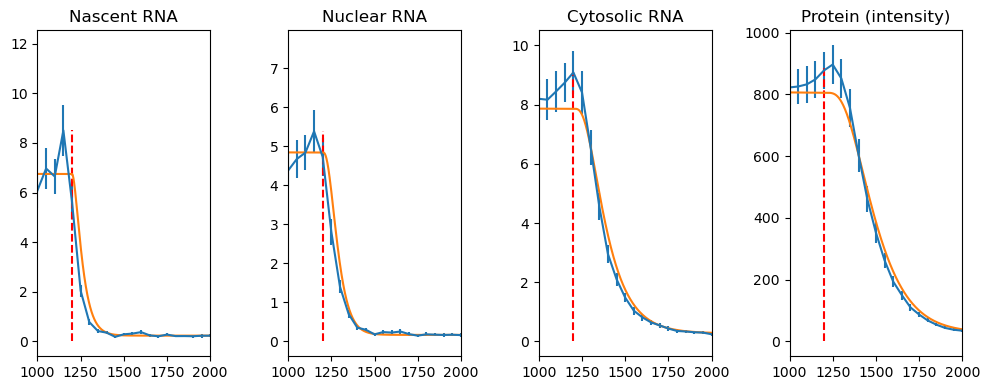

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib import rc

#DRUG 6 (AFFECTS GENE ON/OFF)


# Set up for inline animations in Jupyter
rc('animation', html='jshtml')

# Function to compute the time of the next reaction
def next_time(x, t, W, pars=None):
    return -np.log(np.random.rand()) / np.sum(W(x, t, pars=pars))

# Function to compute the index of the next reaction
def next_reaction(x, t, W, pars, di, ti):
    W_vals = W(x, t, pars=pars, di=di, ti=ti)
    W0 = np.sum(W_vals)
    r = np.random.rand()
    i = 0
    W_sum = W_vals[0]
    while W_sum / W0 < r:
        i += 1
        W_sum += W_vals[i]
    return i

def gillespie_drugs(x0, t0, tmax, S, W, pars, di, ti, returnFullTraj = False):
    # Initialize the time and the state
    t = t0
    x = np.array(x0)
    S = np.array(S)
    
    # Initialize the output (if requested)
    if returnFullTraj:
        times = [t0]
        states = [x0]
    
    # Run the simulation
    while t < tmax:
        # Compute the time of the next reaction
        tau = next_time(x, t, W, pars)
        t += tau
        
        # Exit the loop if the next reaction is beyond tmax
        if t > tmax:
            break
        
        # Compute the index of the next reaction
        i = next_reaction(x, t, W, pars, di, ti)
        
        # Update the state
        x = x + S[:, i]
        
        # Append the results (if requested)
        if returnFullTraj:
            times.append(t)
            states.append(x)

    # Return the results
    if returnFullTraj:
        return np.array(times), np.array(states)
    else:
        return x
    
def dxdt(x, t, pars, di, ti):
    x = np.atleast_2d(x).T
    y = (S @ W(x, t, pars, di, ti)).flatten()
    return y

def solve(S, W, x0, t, pars, di, ti, model='ODE', ntraj=1):
    if model == 'ODE':
        trajectory = odeint(dxdt, np.array(x0), t, args=(pars, di, ti))
    elif model == 'SSA':
        trajectory = np.zeros([ntraj, len(t), len(x0)])
        t0 = t[0]
        tmax = t[-1]
        for i in range(ntraj):
            times, states = gillespie_drugs(x0, t0, tmax, S, W, pars, di, ti, returnFullTraj=True)
            k = 0
            for j in range(len(times)):
                while k < len(t) and times[j] > t[k]:
                    trajectory[i, k, :] = states[j]
                    k += 1
        trajectory = np.mean(trajectory, axis=0)
    return trajectory

def compare_model_to_data(pars, di, ti, x0, drug_number, speciesDict, drug_conc=1000, path='.', model='ODE', ntraj=10):
    if drug_number == 0:
        example_df = pd.read_csv(f'{path}/NoDrug_DesignResults.csv')
    else:
        example_df = pd.read_csv(f'{path}/Drug{drug_number}_{drug_conc}nM_DesignResults.csv')

    t = np.unique(example_df['Time'])
    t_app = example_df['drug_time'].iloc[0]
    data = np.zeros((5, len(t)))
    data_std = np.zeros((5, len(t)))
    k = 0
    for tp in t:
        subdf = example_df[example_df['Time'] == tp]
        subdf = subdf[subdf['is_cell_vital'] == 1]
        data[1, k] = np.mean(subdf['num_rna_nascent'])
        data[2, k] = np.mean(subdf['num_rna_nuc'])
        data[3, k] = np.mean(subdf['num_rna_cyto'])
        data[4, k] = np.mean(subdf['Cyto_Intensity_1'])
        data_std[1, k] = np.std(subdf['num_rna_nascent']) / np.sqrt(len(subdf['num_rna_nascent']))
        data_std[2, k] = np.std(subdf['num_rna_nuc']) / np.sqrt(len(subdf['num_rna_nuc']))
        data_std[3, k] = np.std(subdf['num_rna_cyto']) / np.sqrt(len(subdf['num_rna_cyto']))
        data_std[4, k] = np.std(subdf['Cyto_Intensity_1']) / np.sqrt(len(subdf['Cyto_Intensity_1']))
        k += 1

    fig, ax = plt.subplots(1, 4, tight_layout=True, figsize=(10, 4))
    ax[0].errorbar(t, data[1], yerr=data_std[1])
    ax[1].errorbar(t, data[2], yerr=data_std[2])
    ax[2].errorbar(t, data[3], yerr=data_std[3])
    ax[3].errorbar(t, data[4], yerr=data_std[4])

    ax[0].plot([t_app, t_app], [0, max(data[1])], 'r--', label='_nolegend_')
    ax[1].plot([t_app, t_app], [0, max(data[2])], 'r--', label='_nolegend_')
    ax[2].plot([t_app, t_app], [0, max(data[3])], 'r--', label='_nolegend_')
    ax[3].plot([t_app, t_app], [0, max(data[4])], 'r--', label='_nolegend_')

    ax[0].set_title('Nascent RNA')
    ax[1].set_title('Nuclear RNA')
    ax[2].set_title('Cytosolic RNA')
    ax[3].set_title('Protein (intensity)')

    s = solve(S, W, x0, np.linspace(0, 2000, 2001), pars, di, ti, model=model, ntraj=ntraj)

    ax[0].plot(np.linspace(0, 2000, 2001), s[:, speciesDict['Nascent']])
    ax[1].plot(np.linspace(0, 2000, 2001), s[:, speciesDict['Nuclear']])
    ax[2].plot(np.linspace(0, 2000, 2001), s[:, speciesDict['Cytoplasmic']])
    ax[3].plot(np.linspace(0, 2000, 2001), s[:, speciesDict['Protein']])

    ax[0].set_xlim([1000, 2000])
    ax[1].set_xlim([1000, 2000])
    ax[2].set_xlim([1000, 2000])
    ax[3].set_xlim([1000, 2000])
    plt.show()

# Updated stoichiometry matrix
S = np.array([
    [1, -1,  0,  0,  0,  0,  0,  0,  0],  # gene ON (x1)
    [-1,  1,  0,  0,  0,  0,  0,  0,  0],  # gene OFF (x2)
    [0,  0,  1, -1,  0,  0,  0,  0,  0],  # nascent RNA (x3)
    [0,  0,  0,  1, -1, -1,  0,  0,  0],  # mRNA nuclei (x4)
    [0,  0,  0,  0,  0,  1, -1,  0,  0],  # mRNA cytoplasm (x5)
    [0,  0,  0,  0,  0,  0,  0,  1, -1]   # protein (x6)
])

K = 300 #concentration of the half-maximal response
n = 3

# Hill functions
def hillPositive(x, K=K, n=n):
    return x**n / (K**n + x**n)

def hillNegative(x, K=K, n=n):
    return K**n / (K**n + x**n)

# Propensity functions for the reactions using Hill functions

def W(x, t, pars, di, ti):
    W = [
        pars['k1']*x[1] * ((t < ti[2]) + hillNegative(di[2]) * (t >= ti[2])),  # R1: Gene activation
        pars['k2']*x[0],  # R2: Gene deactivation
        pars['k3']*x[0],  # R3: Nascent RNA synthesis
        pars['k4']*x[2],  # R4: Mature mRNA synthesis
        pars['k5']*x[3] / ((t < ti[3]) + hillNegative(di[3]) * (t >= ti[3])),  # R5: mRNA nuclear degradation
        pars['k6']*x[3] * ((t < ti[0]) + hillNegative(di[0]) * (t >= ti[0])),  # R6: mRNA transport to cytoplasm
        pars['k7']*x[4],  # R7: mRNA cytoplasmic degradation
        pars['k8']*x[4] * ((t < ti[1]) + hillNegative(di[1]) * (t >= ti[1])),  # R8: mRNA cytoplasmic translation
        pars['k9']*x[5] / ((t < ti[4]) + hillNegative(di[4]) * (t >= ti[4]))  # R9: Protein degradation
    ]
    return np.array(W)

# Parameters
pars = {
    'k1': 0.05/4, 'k2': 0.15/4, 'k3': 2.7/4, 'k4': 0.1/4, 'k5': 0.125/6,
    'k6': (0.01/4)*5.6, 'k7': (0.00575/4)*6, 'k8': (0.24/4)*16, 'k9': (0.0025/4)*15}
#k1 = gene activation rate
#k2 = gene deactivation rate
#k3 = nascent RNA synthesis rate
#k4 = mature mRNA synthesis rate
#k5 = mRNA nuclear degradation rate
#k6 = mRNA transport rate
#k7 = mRNA cytoplasmic degradation rate
#k8 = mRNA cytoplasmic translation rate
#k9 = protein degradation rate

# Initial conditions
x0 = np.array([1, 0, 7, 5, 8, 750])
#x0 = gene (DNA) ON
#x1 = gene (DNA) OFF
#x2 = nascent RNA
#x3 = mRNA nuclei
#x4 = mRNA cytoplasm
#x5 = protein

# Drug concentrations and application times
di = [0, 0, 1000,0, 0] #this means 2,4,6,7,10 drugs
ti = [1200, 1200, 1200, 1200, 1200]

# Species dictionary - for plotting
#this is the order of the species in the x0 array above
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}

# Path to data
pathName = "TrueData"
drugNumber = 6 # 0 for no drug, 1 for drug 1, 2 for drug 2

compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict, path=pathName, model='ODE', ntraj=10)


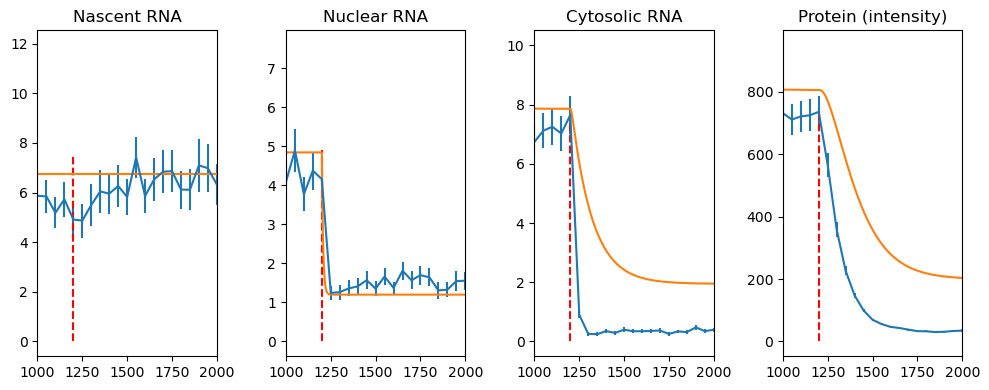

In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib import rc

#DRUG 7 (AFFECTS nuclear mRNA degradation)


# Set up for inline animations in Jupyter
rc('animation', html='jshtml')

# Function to compute the time of the next reaction
def next_time(x, t, W, pars=None):
    return -np.log(np.random.rand()) / np.sum(W(x, t, pars=pars))

# Function to compute the index of the next reaction
def next_reaction(x, t, W, pars, di, ti):
    W_vals = W(x, t, pars=pars, di=di, ti=ti)
    W0 = np.sum(W_vals)
    r = np.random.rand()
    i = 0
    W_sum = W_vals[0]
    while W_sum / W0 < r:
        i += 1
        W_sum += W_vals[i]
    return i

def gillespie_drugs(x0, t0, tmax, S, W, pars, di, ti, returnFullTraj = False):
    # Initialize the time and the state
    t = t0
    x = np.array(x0)
    S = np.array(S)
    
    # Initialize the output (if requested)
    if returnFullTraj:
        times = [t0]
        states = [x0]
    
    # Run the simulation
    while t < tmax:
        # Compute the time of the next reaction
        tau = next_time(x, t, W, pars)
        t += tau
        
        # Exit the loop if the next reaction is beyond tmax
        if t > tmax:
            break
        
        # Compute the index of the next reaction
        i = next_reaction(x, t, W, pars, di, ti)
        
        # Update the state
        x = x + S[:, i]
        
        # Append the results (if requested)
        if returnFullTraj:
            times.append(t)
            states.append(x)

    # Return the results
    if returnFullTraj:
        return np.array(times), np.array(states)
    else:
        return x
    
def dxdt(x, t, pars, di, ti):
    x = np.atleast_2d(x).T
    y = (S @ W(x, t, pars, di, ti)).flatten()
    return y

def solve(S, W, x0, t, pars, di, ti, model='ODE', ntraj=1):
    if model == 'ODE':
        trajectory = odeint(dxdt, np.array(x0), t, args=(pars, di, ti))
    elif model == 'SSA':
        trajectory = np.zeros([ntraj, len(t), len(x0)])
        t0 = t[0]
        tmax = t[-1]
        for i in range(ntraj):
            times, states = gillespie_drugs(x0, t0, tmax, S, W, pars, di, ti, returnFullTraj=True)
            k = 0
            for j in range(len(times)):
                while k < len(t) and times[j] > t[k]:
                    trajectory[i, k, :] = states[j]
                    k += 1
        trajectory = np.mean(trajectory, axis=0)
    return trajectory

def compare_model_to_data(pars, di, ti, x0, drug_number, speciesDict, drug_conc=1000, path='.', model='ODE', ntraj=10):
    if drug_number == 0:
        example_df = pd.read_csv(f'{path}/NoDrug_DesignResults.csv')
    else:
        example_df = pd.read_csv(f'{path}/Drug{drug_number}_{drug_conc}nM_DesignResults.csv')

    t = np.unique(example_df['Time'])
    t_app = example_df['drug_time'].iloc[0]
    data = np.zeros((5, len(t)))
    data_std = np.zeros((5, len(t)))
    k = 0
    for tp in t:
        subdf = example_df[example_df['Time'] == tp]
        subdf = subdf[subdf['is_cell_vital'] == 1]
        data[1, k] = np.mean(subdf['num_rna_nascent'])
        data[2, k] = np.mean(subdf['num_rna_nuc'])
        data[3, k] = np.mean(subdf['num_rna_cyto'])
        data[4, k] = np.mean(subdf['Cyto_Intensity_1'])
        data_std[1, k] = np.std(subdf['num_rna_nascent']) / np.sqrt(len(subdf['num_rna_nascent']))
        data_std[2, k] = np.std(subdf['num_rna_nuc']) / np.sqrt(len(subdf['num_rna_nuc']))
        data_std[3, k] = np.std(subdf['num_rna_cyto']) / np.sqrt(len(subdf['num_rna_cyto']))
        data_std[4, k] = np.std(subdf['Cyto_Intensity_1']) / np.sqrt(len(subdf['Cyto_Intensity_1']))
        k += 1

    fig, ax = plt.subplots(1, 4, tight_layout=True, figsize=(10, 4))
    ax[0].errorbar(t, data[1], yerr=data_std[1])
    ax[1].errorbar(t, data[2], yerr=data_std[2])
    ax[2].errorbar(t, data[3], yerr=data_std[3])
    ax[3].errorbar(t, data[4], yerr=data_std[4])

    ax[0].plot([t_app, t_app], [0, max(data[1])], 'r--', label='_nolegend_')
    ax[1].plot([t_app, t_app], [0, max(data[2])], 'r--', label='_nolegend_')
    ax[2].plot([t_app, t_app], [0, max(data[3])], 'r--', label='_nolegend_')
    ax[3].plot([t_app, t_app], [0, max(data[4])], 'r--', label='_nolegend_')

    ax[0].set_title('Nascent RNA')
    ax[1].set_title('Nuclear RNA')
    ax[2].set_title('Cytosolic RNA')
    ax[3].set_title('Protein (intensity)')

    s = solve(S, W, x0, np.linspace(0, 2000, 2001), pars, di, ti, model=model, ntraj=ntraj)

    ax[0].plot(np.linspace(0, 2000, 2001), s[:, speciesDict['Nascent']])
    ax[1].plot(np.linspace(0, 2000, 2001), s[:, speciesDict['Nuclear']])
    ax[2].plot(np.linspace(0, 2000, 2001), s[:, speciesDict['Cytoplasmic']])
    ax[3].plot(np.linspace(0, 2000, 2001), s[:, speciesDict['Protein']])

    ax[0].set_xlim([1000, 2000])
    ax[1].set_xlim([1000, 2000])
    ax[2].set_xlim([1000, 2000])
    ax[3].set_xlim([1000, 2000])
    plt.show()

# Updated stoichiometry matrix
S = np.array([
    [1, -1,  0,  0,  0,  0,  0,  0,  0],  # gene ON (x1)
    [-1,  1,  0,  0,  0,  0,  0,  0,  0],  # gene OFF (x2)
    [0,  0,  1, -1,  0,  0,  0,  0,  0],  # nascent RNA (x3)
    [0,  0,  0,  1, -1, -1,  0,  0,  0],  # mRNA nuclei (x4)
    [0,  0,  0,  0,  0,  1, -1,  0,  0],  # mRNA cytoplasm (x5)
    [0,  0,  0,  0,  0,  0,  0,  1, -1]   # protein (x6)
])

K = 850 #concentration of the half-maximal response
n = 10 #n is the Hill coefficient it is the steepness of the curve 

# Hill functions
def hillPositive(x, K=K, n=n):
    return x**n / (K**n + x**n)

def hillNegative(x, K=K, n=n):
    return K**n / (K**n + x**n)

# Propensity functions for the reactions using Hill functions

def W(x, t, pars, di, ti):
    W = [
        pars['k1']*x[1] * ((t < ti[2]) + hillNegative(di[2]) * (t >= ti[2])),  # R1: Gene activation
        pars['k2']*x[0],  # R2: Gene deactivation
        pars['k3']*x[0],  # R3: Nascent RNA synthesis
        pars['k4']*x[2],  # R4: Mature mRNA synthesis
        pars['k5']*x[3] / ((t < ti[3]) + hillNegative(di[3]) * (t >= ti[3])),  # R5: mRNA nuclear degradation
        pars['k6']*x[3] * ((t < ti[0]) + hillNegative(di[0]) * (t >= ti[0])),  # R6: mRNA transport to cytoplasm
        pars['k7']*x[4],  # R7: mRNA cytoplasmic degradation
        pars['k8']*x[4] * ((t < ti[1]) + hillNegative(di[1]) * (t >= ti[1])),  # R8: mRNA cytoplasmic translation
        pars['k9']*x[5] / ((t < ti[4]) + hillNegative(di[4]) * (t >= ti[4]))  # R9: Protein degradation
    ]
    return np.array(W)

# Parameters
pars = {
    'k1': 0.05/4, 'k2': 0.15/4, 'k3': 2.7/4, 'k4': 0.1/4, 'k5': 0.125/6,
    'k6': (0.01/4)*5.6, 'k7': (0.00575/4)*6, 'k8': (0.24/4)*16, 'k9': (0.0025/4)*15}
#k1 = gene activation rate
#k2 = gene deactivation rate
#k3 = nascent RNA synthesis rate
#k4 = mature mRNA synthesis rate
#k5 = mRNA nuclear degradation rate
#k6 = mRNA transport rate
#k7 = mRNA cytoplasmic degradation rate
#k8 = mRNA cytoplasmic translation rate
#k9 = protein degradation rate

# Initial conditions
x0 = np.array([1, 0, 7, 5, 8, 750])
#x0 = gene (DNA) ON
#x1 = gene (DNA) OFF
#x2 = nascent RNA
#x3 = mRNA nuclei
#x4 = mRNA cytoplasm
#x5 = protein

# Drug concentrations and application times
di = [0, 0, 0,1000, 0] #this means 2,4,6,7,10 drugs
ti = [1200, 1200, 1200, 1200, 1200]

# Species dictionary - for plotting
#this is the order of the species in the x0 array above
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}

# Path to data
pathName = "TrueData"
drugNumber = 7 # 0 for no drug, 1 for drug 1, 2 for drug 2, etc 

compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict, path=pathName, model='ODE', ntraj=10)


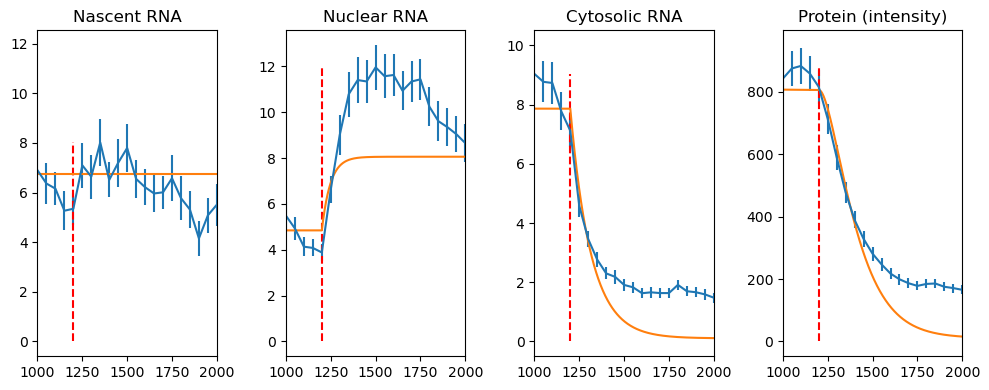

In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib import rc

#DRUG 2 (AFFECTS mRNA transport to cytoplasm)


# Set up for inline animations in Jupyter
rc('animation', html='jshtml')

# Function to compute the time of the next reaction
def next_time(x, t, W, pars=None):
    return -np.log(np.random.rand()) / np.sum(W(x, t, pars=pars))

# Function to compute the index of the next reaction
def next_reaction(x, t, W, pars, di, ti):
    W_vals = W(x, t, pars=pars, di=di, ti=ti)
    W0 = np.sum(W_vals)
    r = np.random.rand()
    i = 0
    W_sum = W_vals[0]
    while W_sum / W0 < r:
        i += 1
        W_sum += W_vals[i]
    return i

def gillespie_drugs(x0, t0, tmax, S, W, pars, di, ti, returnFullTraj = False):
    # Initialize the time and the state
    t = t0
    x = np.array(x0)
    S = np.array(S)
    
    # Initialize the output (if requested)
    if returnFullTraj:
        times = [t0]
        states = [x0]
    
    # Run the simulation
    while t < tmax:
        # Compute the time of the next reaction
        tau = next_time(x, t, W, pars)
        t += tau
        
        # Exit the loop if the next reaction is beyond tmax
        if t > tmax:
            break
        
        # Compute the index of the next reaction
        i = next_reaction(x, t, W, pars, di, ti)
        
        # Update the state
        x = x + S[:, i]
        
        # Append the results (if requested)
        if returnFullTraj:
            times.append(t)
            states.append(x)

    # Return the results
    if returnFullTraj:
        return np.array(times), np.array(states)
    else:
        return x
    
def dxdt(x, t, pars, di, ti):
    x = np.atleast_2d(x).T
    y = (S @ W(x, t, pars, di, ti)).flatten()
    return y

def solve(S, W, x0, t, pars, di, ti, model='ODE', ntraj=1):
    if model == 'ODE':
        trajectory = odeint(dxdt, np.array(x0), t, args=(pars, di, ti))
    elif model == 'SSA':
        trajectory = np.zeros([ntraj, len(t), len(x0)])
        t0 = t[0]
        tmax = t[-1]
        for i in range(ntraj):
            times, states = gillespie_drugs(x0, t0, tmax, S, W, pars, di, ti, returnFullTraj=True)
            k = 0
            for j in range(len(times)):
                while k < len(t) and times[j] > t[k]:
                    trajectory[i, k, :] = states[j]
                    k += 1
        trajectory = np.mean(trajectory, axis=0)
    return trajectory

def compare_model_to_data(pars, di, ti, x0, drug_number, speciesDict, drug_conc=1000, path='.', model='ODE', ntraj=10):
    if drug_number == 0:
        example_df = pd.read_csv(f'{path}/NoDrug_DesignResults.csv')
    else:
        example_df = pd.read_csv(f'{path}/Drug{drug_number}_{drug_conc}nM_DesignResults.csv')

    t = np.unique(example_df['Time'])
    t_app = example_df['drug_time'].iloc[0]
    data = np.zeros((5, len(t)))
    data_std = np.zeros((5, len(t)))
    k = 0
    for tp in t:
        subdf = example_df[example_df['Time'] == tp]
        subdf = subdf[subdf['is_cell_vital'] == 1]
        data[1, k] = np.mean(subdf['num_rna_nascent'])
        data[2, k] = np.mean(subdf['num_rna_nuc'])
        data[3, k] = np.mean(subdf['num_rna_cyto'])
        data[4, k] = np.mean(subdf['Cyto_Intensity_1'])
        data_std[1, k] = np.std(subdf['num_rna_nascent']) / np.sqrt(len(subdf['num_rna_nascent']))
        data_std[2, k] = np.std(subdf['num_rna_nuc']) / np.sqrt(len(subdf['num_rna_nuc']))
        data_std[3, k] = np.std(subdf['num_rna_cyto']) / np.sqrt(len(subdf['num_rna_cyto']))
        data_std[4, k] = np.std(subdf['Cyto_Intensity_1']) / np.sqrt(len(subdf['Cyto_Intensity_1']))
        k += 1

    fig, ax = plt.subplots(1, 4, tight_layout=True, figsize=(10, 4))
    ax[0].errorbar(t, data[1], yerr=data_std[1])
    ax[1].errorbar(t, data[2], yerr=data_std[2])
    ax[2].errorbar(t, data[3], yerr=data_std[3])
    ax[3].errorbar(t, data[4], yerr=data_std[4])

    ax[0].plot([t_app, t_app], [0, max(data[1])], 'r--', label='_nolegend_')
    ax[1].plot([t_app, t_app], [0, max(data[2])], 'r--', label='_nolegend_')
    ax[2].plot([t_app, t_app], [0, max(data[3])], 'r--', label='_nolegend_')
    ax[3].plot([t_app, t_app], [0, max(data[4])], 'r--', label='_nolegend_')

    ax[0].set_title('Nascent RNA')
    ax[1].set_title('Nuclear RNA')
    ax[2].set_title('Cytosolic RNA')
    ax[3].set_title('Protein (intensity)')

    s = solve(S, W, x0, np.linspace(0, 2000, 2001), pars, di, ti, model=model, ntraj=ntraj)

    ax[0].plot(np.linspace(0, 2000, 2001), s[:, speciesDict['Nascent']])
    ax[1].plot(np.linspace(0, 2000, 2001), s[:, speciesDict['Nuclear']])
    ax[2].plot(np.linspace(0, 2000, 2001), s[:, speciesDict['Cytoplasmic']])
    ax[3].plot(np.linspace(0, 2000, 2001), s[:, speciesDict['Protein']])

    ax[0].set_xlim([1000, 2000])
    ax[1].set_xlim([1000, 2000])
    ax[2].set_xlim([1000, 2000])
    ax[3].set_xlim([1000, 2000])
    plt.show()

# Updated stoichiometry matrix
S = np.array([
    [1, -1,  0,  0,  0,  0,  0,  0,  0],  # gene ON (x1)
    [-1,  1,  0,  0,  0,  0,  0,  0,  0],  # gene OFF (x2)
    [0,  0,  1, -1,  0,  0,  0,  0,  0],  # nascent RNA (x3)
    [0,  0,  0,  1, -1, -1,  0,  0,  0],  # mRNA nuclei (x4)
    [0,  0,  0,  0,  0,  1, -1,  0,  0],  # mRNA cytoplasm (x5)
    [0,  0,  0,  0,  0,  0,  0,  1, -1]   # protein (x6)
])

K = 300 #concentration of the half-maximal response
n = 4

# Hill functions
def hillPositive(x, K=K, n=n):
    return x**n / (K**n + x**n)

def hillNegative(x, K=K, n=n):
    return K**n / (K**n + x**n)

# Propensity functions for the reactions using Hill functions

def W(x, t, pars, di, ti):
    W = [
        pars['k1']*x[1] * ((t < ti[2]) + hillNegative(di[2]) * (t >= ti[2])),  # R1: Gene activation
        pars['k2']*x[0],  # R2: Gene deactivation
        pars['k3']*x[0],  # R3: Nascent RNA synthesis
        pars['k4']*x[2],  # R4: Mature mRNA synthesis
        pars['k5']*x[3] / ((t < ti[3]) + hillNegative(di[3]) * (t >= ti[3])),  # R5: mRNA nuclear degradation
        pars['k6']*x[3] * ((t < ti[0]) + hillNegative(di[0]) * (t >= ti[0])),  # R6: mRNA transport to cytoplasm
        pars['k7']*x[4],  # R7: mRNA cytoplasmic degradation
        pars['k8']*x[4] * ((t < ti[1]) + hillNegative(di[1]) * (t >= ti[1])),  # R8: mRNA cytoplasmic translation
        pars['k9']*x[5] / ((t < ti[4]) + hillNegative(di[4]) * (t >= ti[4]))  # R9: Protein degradation
    ]
    return np.array(W)

# Parameters
pars = {
    'k1': 0.05/4, 'k2': 0.15/4, 'k3': 2.7/4, 'k4': 0.1/4, 'k5': 0.125/6,
    'k6': (0.01/4)*5.6, 'k7': (0.00575/4)*6, 'k8': (0.24/4)*16, 'k9': (0.0025/4)*15}
#k1 = gene activation rate
#k2 = gene deactivation rate
#k3 = nascent RNA synthesis rate
#k4 = mature mRNA synthesis rate
#k5 = mRNA nuclear degradation rate
#k6 = mRNA transport rate
#k7 = mRNA cytoplasmic degradation rate
#k8 = mRNA cytoplasmic translation rate
#k9 = protein degradation rate

# Initial conditions
x0 = np.array([1, 0, 7, 5, 8, 750])
#x0 = gene (DNA) ON
#x1 = gene (DNA) OFF
#x2 = nascent RNA
#x3 = mRNA nuclei
#x4 = mRNA cytoplasm
#x5 = protein

# Drug concentrations and application times
di = [1000, 0, 0,0, 0] #this means 2,4,6,7,10 drugs
ti = [1200, 1200, 1200, 1200, 1200]

# Species dictionary - for plotting
#this is the order of the species in the x0 array above
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}

# Path to data
pathName = "TrueData"
drugNumber = 2 # 0 for no drug, 1 for drug 1, 2 for drug 2

compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict, path=pathName, model='ODE', ntraj=10)


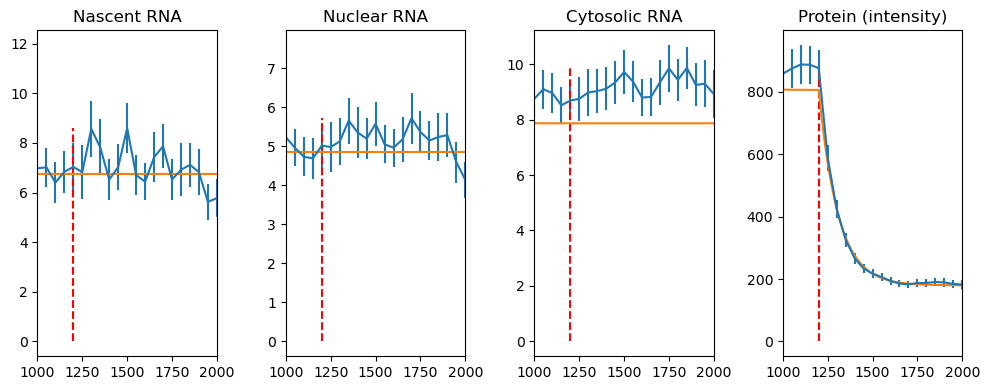

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib import rc

#DRUG 4 (AFFECTS TRANSLATION)


# Set up for inline animations in Jupyter
rc('animation', html='jshtml')

# Function to compute the time of the next reaction
def next_time(x, t, W, pars=None):
    return -np.log(np.random.rand()) / np.sum(W(x, t, pars=pars))

# Function to compute the index of the next reaction
def next_reaction(x, t, W, pars, di, ti):
    W_vals = W(x, t, pars=pars, di=di, ti=ti)
    W0 = np.sum(W_vals)
    r = np.random.rand()
    i = 0
    W_sum = W_vals[0]
    while W_sum / W0 < r:
        i += 1
        W_sum += W_vals[i]
    return i

def gillespie_drugs(x0, t0, tmax, S, W, pars, di, ti, returnFullTraj = False):
    # Initialize the time and the state
    t = t0
    x = np.array(x0)
    S = np.array(S)
    
    # Initialize the output (if requested)
    if returnFullTraj:
        times = [t0]
        states = [x0]
    
    # Run the simulation
    while t < tmax:
        # Compute the time of the next reaction
        tau = next_time(x, t, W, pars)
        t += tau
        
        # Exit the loop if the next reaction is beyond tmax
        if t > tmax:
            break
        
        # Compute the index of the next reaction
        i = next_reaction(x, t, W, pars, di, ti)
        
        # Update the state
        x = x + S[:, i]
        
        # Append the results (if requested)
        if returnFullTraj:
            times.append(t)
            states.append(x)

    # Return the results
    if returnFullTraj:
        return np.array(times), np.array(states)
    else:
        return x
    
def dxdt(x, t, pars, di, ti):
    x = np.atleast_2d(x).T
    y = (S @ W(x, t, pars, di, ti)).flatten()
    return y

def solve(S, W, x0, t, pars, di, ti, model='ODE', ntraj=1):
    if model == 'ODE':
        trajectory = odeint(dxdt, np.array(x0), t, args=(pars, di, ti))
    elif model == 'SSA':
        trajectory = np.zeros([ntraj, len(t), len(x0)])
        t0 = t[0]
        tmax = t[-1]
        for i in range(ntraj):
            times, states = gillespie_drugs(x0, t0, tmax, S, W, pars, di, ti, returnFullTraj=True)
            k = 0
            for j in range(len(times)):
                while k < len(t) and times[j] > t[k]:
                    trajectory[i, k, :] = states[j]
                    k += 1
        trajectory = np.mean(trajectory, axis=0)
    return trajectory

def compare_model_to_data(pars, di, ti, x0, drug_number, speciesDict, drug_conc=1000, path='.', model='ODE', ntraj=10):
    if drug_number == 0:
        example_df = pd.read_csv(f'{path}/NoDrug_DesignResults.csv')
    else:
        example_df = pd.read_csv(f'{path}/Drug{drug_number}_{drug_conc}nM_DesignResults.csv')

    t = np.unique(example_df['Time'])
    t_app = example_df['drug_time'].iloc[0]
    data = np.zeros((5, len(t)))
    data_std = np.zeros((5, len(t)))
    k = 0
    for tp in t:
        subdf = example_df[example_df['Time'] == tp]
        subdf = subdf[subdf['is_cell_vital'] == 1]
        data[1, k] = np.mean(subdf['num_rna_nascent'])
        data[2, k] = np.mean(subdf['num_rna_nuc'])
        data[3, k] = np.mean(subdf['num_rna_cyto'])
        data[4, k] = np.mean(subdf['Cyto_Intensity_1'])
        data_std[1, k] = np.std(subdf['num_rna_nascent']) / np.sqrt(len(subdf['num_rna_nascent']))
        data_std[2, k] = np.std(subdf['num_rna_nuc']) / np.sqrt(len(subdf['num_rna_nuc']))
        data_std[3, k] = np.std(subdf['num_rna_cyto']) / np.sqrt(len(subdf['num_rna_cyto']))
        data_std[4, k] = np.std(subdf['Cyto_Intensity_1']) / np.sqrt(len(subdf['Cyto_Intensity_1']))
        k += 1

    fig, ax = plt.subplots(1, 4, tight_layout=True, figsize=(10, 4))
    ax[0].errorbar(t, data[1], yerr=data_std[1])
    ax[1].errorbar(t, data[2], yerr=data_std[2])
    ax[2].errorbar(t, data[3], yerr=data_std[3])
    ax[3].errorbar(t, data[4], yerr=data_std[4])

    ax[0].plot([t_app, t_app], [0, max(data[1])], 'r--', label='_nolegend_')
    ax[1].plot([t_app, t_app], [0, max(data[2])], 'r--', label='_nolegend_')
    ax[2].plot([t_app, t_app], [0, max(data[3])], 'r--', label='_nolegend_')
    ax[3].plot([t_app, t_app], [0, max(data[4])], 'r--', label='_nolegend_')

    ax[0].set_title('Nascent RNA')
    ax[1].set_title('Nuclear RNA')
    ax[2].set_title('Cytosolic RNA')
    ax[3].set_title('Protein (intensity)')

    s = solve(S, W, x0, np.linspace(0, 2000, 2001), pars, di, ti, model=model, ntraj=ntraj)

    ax[0].plot(np.linspace(0, 2000, 2001), s[:, speciesDict['Nascent']])
    ax[1].plot(np.linspace(0, 2000, 2001), s[:, speciesDict['Nuclear']])
    ax[2].plot(np.linspace(0, 2000, 2001), s[:, speciesDict['Cytoplasmic']])
    ax[3].plot(np.linspace(0, 2000, 2001), s[:, speciesDict['Protein']])

    ax[0].set_xlim([1000, 2000])
    ax[1].set_xlim([1000, 2000])
    ax[2].set_xlim([1000, 2000])
    ax[3].set_xlim([1000, 2000])
    plt.show()

# Updated stoichiometry matrix
S = np.array([
    [1, -1,  0,  0,  0,  0,  0,  0,  0],  # gene ON (x1)
    [-1,  1,  0,  0,  0,  0,  0,  0,  0],  # gene OFF (x2)
    [0,  0,  1, -1,  0,  0,  0,  0,  0],  # nascent RNA (x3)
    [0,  0,  0,  1, -1, -1,  0,  0,  0],  # mRNA nuclei (x4)
    [0,  0,  0,  0,  0,  1, -1,  0,  0],  # mRNA cytoplasm (x5)
    [0,  0,  0,  0,  0,  0,  0,  1, -1]   # protein (x6)
])

K = 700 #concentration of the half-maximal response
n = 3.5

# Hill functions
def hillPositive(x, K=K, n=n):
    return x**n / (K**n + x**n)

def hillNegative(x, K=K, n=n):
    return K**n / (K**n + x**n)

# Propensity functions for the reactions using Hill functions

def W(x, t, pars, di, ti):
    W = [
        pars['k1']*x[1] * ((t < ti[2]) + hillNegative(di[2]) * (t >= ti[2])),  # R1: Gene activation
        pars['k2']*x[0],  # R2: Gene deactivation
        pars['k3']*x[0],  # R3: Nascent RNA synthesis
        pars['k4']*x[2],  # R4: Mature mRNA synthesis
        pars['k5']*x[3] / ((t < ti[3]) + hillNegative(di[3]) * (t >= ti[3])),  # R5: mRNA nuclear degradation
        pars['k6']*x[3] * ((t < ti[0]) + hillNegative(di[0]) * (t >= ti[0])),  # R6: mRNA transport to cytoplasm
        pars['k7']*x[4],  # R7: mRNA cytoplasmic degradation
        pars['k8']*x[4] * ((t < ti[1]) + hillNegative(di[1]) * (t >= ti[1])),  # R8: mRNA cytoplasmic translation
        pars['k9']*x[5] / ((t < ti[4]) + hillNegative(di[4]) * (t >= ti[4]))  # R9: Protein degradation
    ]
    return np.array(W)

# Parameters
pars = {
    'k1': 0.05/4, 'k2': 0.15/4, 'k3': 2.7/4, 'k4': 0.1/4, 'k5': 0.125/6,
    'k6': (0.01/4)*5.6, 'k7': (0.00575/4)*6, 'k8': (0.24/4)*16, 'k9': (0.0025/4)*15}
#k1 = gene activation rate
#k2 = gene deactivation rate
#k3 = nascent RNA synthesis rate
#k4 = mature mRNA synthesis rate
#k5 = mRNA nuclear degradation rate
#k6 = mRNA transport rate
#k7 = mRNA cytoplasmic degradation rate
#k8 = mRNA cytoplasmic translation rate
#k9 = protein degradation rate

# Initial conditions
x0 = np.array([1, 0, 7, 5, 8, 750])
#x0 = gene (DNA) ON
#x1 = gene (DNA) OFF
#x2 = nascent RNA
#x3 = mRNA nuclei
#x4 = mRNA cytoplasm
#x5 = protein

# Drug concentrations and application times
di = [0, 1000, 0,0, 0] #this means 2,4,6,7,10 drugs
ti = [1200, 1200, 1200, 1200, 1200]

# Species dictionary - for plotting
#this is the order of the species in the x0 array above
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}

# Path to data
pathName = "TrueData"
drugNumber = 4 # 0 for no drug, 1 for drug 1, 2 for drug 2

compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict, path=pathName, model='ODE', ntraj=10)


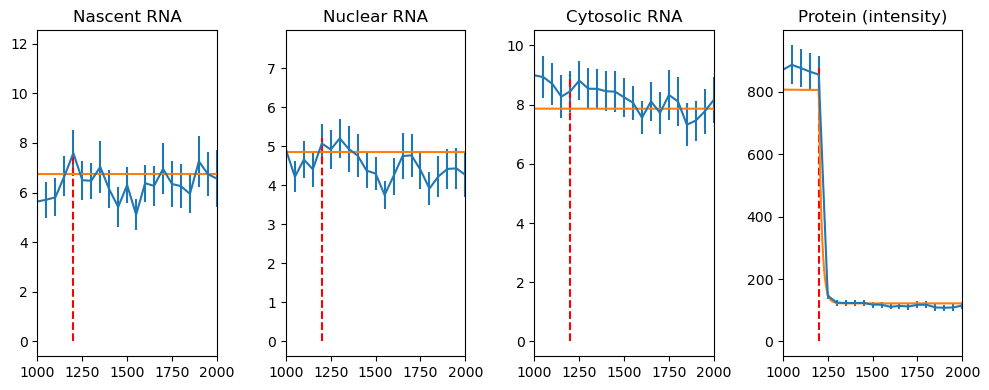

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib import rc

#DRUG 10 (AFFECTS PROTEIN DEGRADATION)


# Set up for inline animations in Jupyter
rc('animation', html='jshtml')

# Function to compute the time of the next reaction
def next_time(x, t, W, pars=None):
    return -np.log(np.random.rand()) / np.sum(W(x, t, pars=pars))

# Function to compute the index of the next reaction
def next_reaction(x, t, W, pars, di, ti):
    W_vals = W(x, t, pars=pars, di=di, ti=ti)
    W0 = np.sum(W_vals)
    r = np.random.rand()
    i = 0
    W_sum = W_vals[0]
    while W_sum / W0 < r:
        i += 1
        W_sum += W_vals[i]
    return i

def gillespie_drugs(x0, t0, tmax, S, W, pars, di, ti, returnFullTraj = False):
    # Initialize the time and the state
    t = t0
    x = np.array(x0)
    S = np.array(S)
    
    # Initialize the output (if requested)
    if returnFullTraj:
        times = [t0]
        states = [x0]
    
    # Run the simulation
    while t < tmax:
        # Compute the time of the next reaction
        tau = next_time(x, t, W, pars)
        t += tau
        
        # Exit the loop if the next reaction is beyond tmax
        if t > tmax:
            break
        
        # Compute the index of the next reaction
        i = next_reaction(x, t, W, pars, di, ti)
        
        # Update the state
        x = x + S[:, i]
        
        # Append the results (if requested)
        if returnFullTraj:
            times.append(t)
            states.append(x)

    # Return the results
    if returnFullTraj:
        return np.array(times), np.array(states)
    else:
        return x
    
def dxdt(x, t, pars, di, ti):
    x = np.atleast_2d(x).T
    y = (S @ W(x, t, pars, di, ti)).flatten()
    return y

def solve(S, W, x0, t, pars, di, ti, model='ODE', ntraj=1):
    if model == 'ODE':
        trajectory = odeint(dxdt, np.array(x0), t, args=(pars, di, ti))
    elif model == 'SSA':
        trajectory = np.zeros([ntraj, len(t), len(x0)])
        t0 = t[0]
        tmax = t[-1]
        for i in range(ntraj):
            times, states = gillespie_drugs(x0, t0, tmax, S, W, pars, di, ti, returnFullTraj=True)
            k = 0
            for j in range(len(times)):
                while k < len(t) and times[j] > t[k]:
                    trajectory[i, k, :] = states[j]
                    k += 1
        trajectory = np.mean(trajectory, axis=0)
    return trajectory

def compare_model_to_data(pars, di, ti, x0, drug_number, speciesDict, drug_conc=1000, path='.', model='ODE', ntraj=10):
    if drug_number == 0:
        example_df = pd.read_csv(f'{path}/NoDrug_DesignResults.csv')
    else:
        example_df = pd.read_csv(f'{path}/Drug{drug_number}_{drug_conc}nM_DesignResults.csv')

    t = np.unique(example_df['Time'])
    t_app = example_df['drug_time'].iloc[0]
    data = np.zeros((5, len(t)))
    data_std = np.zeros((5, len(t)))
    k = 0
    for tp in t:
        subdf = example_df[example_df['Time'] == tp]
        subdf = subdf[subdf['is_cell_vital'] == 1]
        data[1, k] = np.mean(subdf['num_rna_nascent'])
        data[2, k] = np.mean(subdf['num_rna_nuc'])
        data[3, k] = np.mean(subdf['num_rna_cyto'])
        data[4, k] = np.mean(subdf['Cyto_Intensity_1'])
        data_std[1, k] = np.std(subdf['num_rna_nascent']) / np.sqrt(len(subdf['num_rna_nascent']))
        data_std[2, k] = np.std(subdf['num_rna_nuc']) / np.sqrt(len(subdf['num_rna_nuc']))
        data_std[3, k] = np.std(subdf['num_rna_cyto']) / np.sqrt(len(subdf['num_rna_cyto']))
        data_std[4, k] = np.std(subdf['Cyto_Intensity_1']) / np.sqrt(len(subdf['Cyto_Intensity_1']))
        k += 1

    fig, ax = plt.subplots(1, 4, tight_layout=True, figsize=(10, 4))
    ax[0].errorbar(t, data[1], yerr=data_std[1])
    ax[1].errorbar(t, data[2], yerr=data_std[2])
    ax[2].errorbar(t, data[3], yerr=data_std[3])
    ax[3].errorbar(t, data[4], yerr=data_std[4])

    ax[0].plot([t_app, t_app], [0, max(data[1])], 'r--', label='_nolegend_')
    ax[1].plot([t_app, t_app], [0, max(data[2])], 'r--', label='_nolegend_')
    ax[2].plot([t_app, t_app], [0, max(data[3])], 'r--', label='_nolegend_')
    ax[3].plot([t_app, t_app], [0, max(data[4])], 'r--', label='_nolegend_')

    ax[0].set_title('Nascent RNA')
    ax[1].set_title('Nuclear RNA')
    ax[2].set_title('Cytosolic RNA')
    ax[3].set_title('Protein (intensity)')

    s = solve(S, W, x0, np.linspace(0, 2000, 2001), pars, di, ti, model=model, ntraj=ntraj)

    ax[0].plot(np.linspace(0, 2000, 2001), s[:, speciesDict['Nascent']])
    ax[1].plot(np.linspace(0, 2000, 2001), s[:, speciesDict['Nuclear']])
    ax[2].plot(np.linspace(0, 2000, 2001), s[:, speciesDict['Cytoplasmic']])
    ax[3].plot(np.linspace(0, 2000, 2001), s[:, speciesDict['Protein']])

    ax[0].set_xlim([1000, 2000])
    ax[1].set_xlim([1000, 2000])
    ax[2].set_xlim([1000, 2000])
    ax[3].set_xlim([1000, 2000])
    plt.show()

# Updated stoichiometry matrix
S = np.array([
    [1, -1,  0,  0,  0,  0,  0,  0,  0],  # gene ON (x1)
    [-1,  1,  0,  0,  0,  0,  0,  0,  0],  # gene OFF (x2)
    [0,  0,  1, -1,  0,  0,  0,  0,  0],  # nascent RNA (x3)
    [0,  0,  0,  1, -1, -1,  0,  0,  0],  # mRNA nuclei (x4)
    [0,  0,  0,  0,  0,  1, -1,  0,  0],  # mRNA cytoplasm (x5)
    [0,  0,  0,  0,  0,  0,  0,  1, -1]   # protein (x6)
])

K = 650 #concentration of the half-maximal response
n = 4

# Hill functions
def hillPositive(x, K=K, n=n):
    return x**n / (K**n + x**n)

def hillNegative(x, K=K, n=n):
    return K**n / (K**n + x**n)

# Propensity functions for the reactions using Hill functions

def W(x, t, pars, di, ti):
    W = [
        pars['k1']*x[1] * ((t < ti[2]) + hillNegative(di[2]) * (t >= ti[2])),  # R1: Gene activation
        pars['k2']*x[0],  # R2: Gene deactivation
        pars['k3']*x[0],  # R3: Nascent RNA synthesis
        pars['k4']*x[2],  # R4: Mature mRNA synthesis
        pars['k5']*x[3] / ((t < ti[3]) + hillNegative(di[3]) * (t >= ti[3])),  # R5: mRNA nuclear degradation
        pars['k6']*x[3] * ((t < ti[0]) + hillNegative(di[0]) * (t >= ti[0])),  # R6: mRNA transport to cytoplasm
        pars['k7']*x[4],  # R7: mRNA cytoplasmic degradation
        pars['k8']*x[4] * ((t < ti[1]) + hillNegative(di[1]) * (t >= ti[1])),  # R8: mRNA cytoplasmic translation
        pars['k9']*x[5] / ((t < ti[4]) + hillNegative(di[4]) * (t >= ti[4]))  # R9: Protein degradation
    ]
    return np.array(W)

# Parameters
pars = {
    'k1': 0.05/4, 'k2': 0.15/4, 'k3': 2.7/4, 'k4': 0.1/4, 'k5': 0.125/6,
    'k6': (0.01/4)*5.6, 'k7': (0.00575/4)*6, 'k8': (0.24/4)*16, 'k9': (0.0025/4)*15}
#k1 = gene activation rate
#k2 = gene deactivation rate
#k3 = nascent RNA synthesis rate
#k4 = mature mRNA synthesis rate
#k5 = mRNA nuclear degradation rate
#k6 = mRNA transport rate
#k7 = mRNA cytoplasmic degradation rate
#k8 = mRNA cytoplasmic translation rate
#k9 = protein degradation rate

# Initial conditions
x0 = np.array([1, 0, 7, 5, 8, 750])
#x0 = gene (DNA) ON
#x1 = gene (DNA) OFF
#x2 = nascent RNA
#x3 = mRNA nuclei
#x4 = mRNA cytoplasm
#x5 = protein

# Drug concentrations and application times
di = [0, 0, 0,0, 1000] #this means 2,4,6,7,10 drugs
ti = [1200, 1200, 1200, 1200, 1200]

# Species dictionary - for plotting
#this is the order of the species in the x0 array above
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}

# Path to data
pathName = "TrueData"
drugNumber = 10 # 0 for no drug, 1 for drug 1, 2 for drug 2

compare_model_to_data(pars, di, ti, x0, drugNumber, speciesDict, path=pathName, model='ODE', ntraj=10)
